# NFL Combine Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import pickle
from scipy.stats import levene
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

Import NFL Combine results from 2010-2020

In [2]:
combine10 = pd.read_csv("Files\combine2010.csv")
combine11 = pd.read_csv("Files\combine2011.csv")
combine12 = pd.read_csv("Files\combine2012.csv")
combine13 = pd.read_csv("Files\combine2013.csv")
combine14 = pd.read_csv("Files\combine2014.csv")
combine15 = pd.read_csv("Files\combine2015.csv")
combine16 = pd.read_csv("Files\combine2016.csv")
combine17 = pd.read_csv("Files\combine2017.csv")
combine18 = pd.read_csv("Files\combine2018.csv")
combine19 = pd.read_csv("Files\combine2019.csv")
combine20 = pd.read_csv("Files\combine2020.csv")

Join all the results into a clean dataframe and get rid of the "College" column before analysis 

In [3]:
df = pd.concat([combine12,combine13,combine14,combine15,combine16,combine17,combine18,combine18,combine20])
df.columns = ['Player', 'Position', 'School', 'College', 'Height', 'Weight', '40Yard', 'Vertical', 'Bench', 'Broad', 
              '3Cone', 'Shuttle', 'Drafted']
del df['College']

Delete rows where athlete missed > 2 tests

In [4]:
df = df.dropna(subset = ['40Yard', 'Vertical', 'Bench', 'Broad', '3Cone', 'Shuttle'], thresh = 4)

Imputate with column means

In [5]:
df = df.apply(lambda x: x.fillna(x.mean()) if x.dtypes != 'O' else x) 

Clean up the player's name column

In [6]:
df[['Name', 'ID']] = df.Player.apply(lambda x: pd.Series(str(x).split("\\")))
del df['Player']

Convert Height from "6-2" format into "74" for analysis

In [7]:
df[['Feet','Inches']] = df['Height'].str.split('-', 1, expand=True)
df.Feet = df.Feet.astype(int)
df.Inches = df.Inches.astype(int)
df['Height'] = (12 * df['Feet']) + df['Inches']

Turn the "Drafted" column binary for classification

In [8]:
df['Drafted'] = df['Drafted'].notnull().astype(int)

One hot encode the position column

In [9]:
dfohe = pd.concat([pd.get_dummies(df['Position']), df], axis = 1)
dfohe = dfohe.drop(['Feet', 'Inches', 'Position', 'ID'], axis = 1)

Get Numerical columns

In [10]:
normCols = ['Height', 'Weight', '40Yard', 'Vertical', 'Bench', 'Broad', '3Cone', 'Shuttle']
dfnorm = df[normCols]

Normalize

In [11]:
dfnorm=(dfnorm-dfnorm.mean())/dfnorm.std()

Join dataframes from above

In [12]:
dfclean = pd.concat([dfohe.drop(normCols, axis=1), dfnorm], axis = 1)
dfclean = dfclean.dropna()

Feature variables

In [13]:
x = dfclean.drop(['School', 'Name', 'Drafted'], axis = 1)
X = x.values

Target variable

In [14]:
y = dfclean.Drafted
Y = y.values

Initialize machine learning models

In [15]:
logreg = LogisticRegression(random_state = 1)
rf = RandomForestClassifier(random_state = 1)
gnb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors = 3)

Create lists for the model accuracies

In [16]:
logacc = []
rfacc = []
gnbacc = []
knnacc = []

Start 10-Fold Cross-Validation

Prints out a confusion matrix and the accuracy (top-right value in confusion matrix are athletes we predicted not to get drafted and were actually drafted i.e. false positives)

In [17]:
kf = KFold(n_splits=10)
for k, (train, test) in enumerate(kf.split(X, Y)):
    
    # Logistic Regression
    print("\n")
    print("===== Logistic Regression =====")
    logreg.fit(X[train], Y[train])
    logpred = logreg.predict(X[test])
    logcm = confusion_matrix(Y[test], logpred) # tn,fp,fn,tp = logcm.ravel()
    print(logcm)
    loga = metrics.accuracy_score(Y[test], logpred)
    logacc.append(loga)
    print("Accuracy:", metrics.accuracy_score(Y[test], logpred))
    
    # Random Forest
    print("\n")
    print("===== Random Forest =====")
    rf.fit(X[train], Y[train])
    rfpred = rf.predict(X[test])
    rfcm = confusion_matrix(Y[test], rfpred) # tn,fp,fn,tp = rfcm.ravel()
    print(rfcm)
    rfa = metrics.accuracy_score(Y[test], rfpred)
    rfacc.append(rfa)
    print("Accuracy:", metrics.accuracy_score(Y[test], rfpred))
    
    # Naive Bayes
    print("\n")
    print("===== Naive Bayes =====")
    gnb.fit(X[train], Y[train])
    gnbpred = gnb.predict(X[test])
    gnbcm = confusion_matrix(Y[test], gnbpred) # tn,fp,fn,tp = logcm.ravel()
    print(gnbcm)
    gnba = metrics.accuracy_score(Y[test], gnbpred)
    gnbacc.append(gnba)
    print("Accuracy:", metrics.accuracy_score(Y[test], gnbpred))
    
    # KNN
    print("\n")
    print("===== K-Nearest Neighbors =====")
    knn.fit(X[train], Y[train])
    knnpred = knn.predict(X[test])
    knncm = confusion_matrix(Y[test], knnpred) # tn,fp,fn,tp = logcm.ravel()
    print(knncm)
    knna = metrics.accuracy_score(Y[test], knnpred)
    knnacc.append(knna)
    print("Accuracy:", metrics.accuracy_score(Y[test], knnpred))



===== Logistic Regression =====
[[  6  69]
 [  2 142]]
Accuracy: 0.6757990867579908


===== Random Forest =====
[[ 10  65]
 [  6 138]]
Accuracy: 0.6757990867579908


===== Naive Bayes =====
[[  1  74]
 [  3 141]]
Accuracy: 0.6484018264840182


===== K-Nearest Neighbors =====
[[ 22  53]
 [ 28 116]]
Accuracy: 0.6301369863013698


===== Logistic Regression =====
[[ 26  43]
 [ 19 131]]
Accuracy: 0.7168949771689498


===== Random Forest =====
[[ 26  43]
 [ 14 136]]
Accuracy: 0.7397260273972602


===== Naive Bayes =====
[[  4  65]
 [  1 149]]
Accuracy: 0.6986301369863014


===== K-Nearest Neighbors =====
[[ 21  48]
 [ 43 107]]
Accuracy: 0.5844748858447488


===== Logistic Regression =====
[[ 21  46]
 [ 17 134]]
Accuracy: 0.7110091743119266


===== Random Forest =====
[[ 18  49]
 [ 23 128]]
Accuracy: 0.6697247706422018


===== Naive Bayes =====
[[  3  64]
 [  0 151]]
Accuracy: 0.7064220183486238


===== K-Nearest Neighbors =====
[[ 24  43]
 [ 33 118]]
Accuracy: 0.6513761467889908


===== Lo

Display the mean accuracies for each model over all the folds

In [18]:
logmean = np.mean(logacc)
rfmean = np.mean(rfacc)
gnbmean = np.mean(gnbacc)
knnmean = np.mean(knnacc)

print("Logistic Regression Cross-Validation Mean: " + str(logmean.round(3)))
print("Random Forest Cross-Validation Mean: " + str(rfmean.round(3)))
print("Naive Bayes Cross-Validation Mean: " + str(gnbmean.round(3)))
print("KNN Cross-Validation Mean: " + str(knnmean.round(3)))

Logistic Regression Cross-Validation Mean: 0.697
Random Forest Cross-Validation Mean: 0.77
Naive Bayes Cross-Validation Mean: 0.638
KNN Cross-Validation Mean: 0.659


Make dataframe for significance testing and model comparison

In [19]:
resultlist = np.asarray(logacc + rfacc + gnbacc + knnacc, dtype = np.float32)
testlist = np.repeat(np.array(["LogisticRegression", "RandomForest", "NaiveBayes", "KNN"]), 10)
resultdf = pd.DataFrame({"Model": testlist, "Accuracy": resultlist})

Compare model accuracies from cross-validation

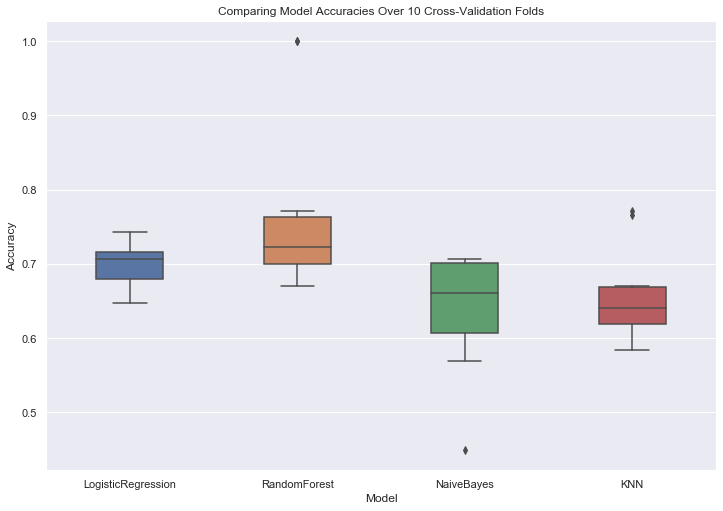

In [23]:
sns.boxplot(x = resultdf['Model'], y = resultdf['Accuracy'], width = 0.4)
sns.set(rc={'figure.figsize':(12,8.27)})
plt.title("Comparing Model Accuracies Over 10 Cross-Validation Folds")
plt.show()

Start significance testing

In [21]:
# Levene Test
levenep = levene(logacc, rfacc, gnbacc, knnacc)[1]

# Run ANOVA if No Violation
if levenep > 0.05:
    anova = f_oneway(logacc, rfacc, gnbacc, knnacc)[1]
    
    # Run Tukey Test if Significant to Find Which Group Differs
    if anova < 0.05:
      
        # Tukey
        print(pairwise_tukeyhsd(resultdf['Accuracy'], resultdf['Model']))

            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1             group2       meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------------
               KNN LogisticRegression   0.0375 0.7176 -0.0617 0.1368  False
               KNN         NaiveBayes  -0.0212    0.9 -0.1204 0.0781  False
               KNN       RandomForest   0.1114 0.0228  0.0121 0.2106   True
LogisticRegression         NaiveBayes  -0.0587 0.3967  -0.158 0.0406  False
LogisticRegression       RandomForest   0.0738 0.2057 -0.0254 0.1731  False
        NaiveBayes       RandomForest   0.1325 0.0051  0.0333 0.2318   True
---------------------------------------------------------------------------


Display most important features for Random Forest model

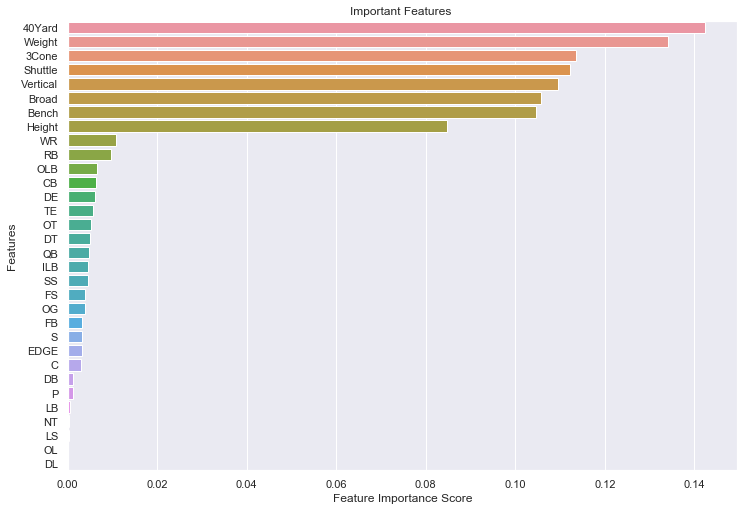

In [22]:
feature_imp = pd.Series(rf.feature_importances_, index = x.columns).sort_values(ascending = False)

sns.barplot(x = feature_imp, y = feature_imp.index)
sns.set(rc={'figure.figsize':(12,8.27)})
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features ")
plt.show()